# Introduction to Word Embeddings

In this notebook, we are going to see:,  

1.   how to create word embeddings from scratch
2.   how to use them to compute the similarity between words
3.   how to plot them
4.   how to use them for downstream tasks


In [ ]:
!pip install --upgrade --force-reinstall ipykernel==5.5.5
!python3 -m ipykernel --upgrade --force-reinstall install --user --name=python3.8
import sys
print(sys.version)
!pip install --upgrade --force-reinstall gensim==3.6.0

Gensim is a pretty easy to use library to generate word embeddings. Essentially, you just need to put the text in and you will get the embeddings out

In [ ]:
sentences = ["The cat is on the table",
             "Where is the cat?",
             "I like dogs"]

In [ ]:
sentences = [k.split() for k in sentences]

In [ ]:
sentences

In [ ]:
from gensim.models import Word2Vec


model = Word2Vec(sentences, min_count=0, size=12, window=3)

vocabulary = list(model.wv.vocab)

print(vocabulary)


In [ ]:
model.wv.vocab["the"].count

In [ ]:
model.wv["the"]

Now, it might be better to use some more meaningful text.

In [ ]:
!wget https://raw.githubusercontent.com/vinid/data/master/dbpedia_sample_abstract_20k_prep.txt

In [ ]:
import string

def simple_preproc(text):
  """
  see: https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string
  """
  return text.translate(str.maketrans('', '', string.punctuation))

with open("dbpedia_sample_abstract_20k_prep.txt") as read_file:
  sentences = [simple_preproc(k).lower().split() for k in read_file.readlines()]

In [ ]:
len(sentences)

In [ ]:
sentences[0]

In [ ]:
model = Word2Vec(sentences, min_count=5, iter=5, size=24)

With a simple function, you can get the most similar words to a given one. Essentially, given a word, gensim will look at the neighborhood of that word and tell you which are the most similar ones (considering cosine distance)

In [ ]:
model.wv.most_similar("computer")

In [ ]:
from scipy.spatial.distance import cosine

1 - cosine(model.wv["house"], model.wv["student"])

In [ ]:
model.wv["science"]

# Pretrained Word Embeddings

Training embeddings from scratch is something that you might not always need. You can obviously save/load yours/others embeddings, but gensim offers you the possibility to get "popular embeddings" with a simple API.

We will now load the popular google-news embedding. This embedding contains 300 dimensional word representations.

In [ ]:
import gensim.downloader as api

## download the model
#model = api.load("word2vec-google-news-300")

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
from google.colab import drive
drive.mount('/content/drive')

print("Now create a shortcut for the folder `Hands_On_W2V` to your Drive")

In [ ]:
## load the model from file
model = Word2VecKeyedVectors.load_word2vec_format('/content/drive/MyDrive/Hands_On_W2V/word2vec-google-news-300.gz', binary=True)

## Exercise
Try to obtain the capital of France (Paris) knowning that Rome is the capital of Italy by using the model.

Remind that with Word2Vec it is possible to obtain semantically meaningful relations between words by using simple algebraic operations.

Useful functions:
- `model[word]` --> the embedding of the word (as a numpy array)
- `model.similar_by_vector(vector)` --> obtains most similar vectors
- `emb_sum = emb_1 + emb_2` --> numpy array supports simple algebraic operations like they where numbers.

In [ ]:
### YOUR CODE HERE ###



### Solutions

In [ ]:
# v(Rome) - v(Italy) + v (France)
model.similar_by_vector(model["Rome"] - model["Italy"] + model["France"])

In [ ]:
# or with most_similar
model.most_similar(positive=["Rome", "France"], negative=["Italy"])

In [ ]:
print("Rome-Milan", model.similarity("Rome", "Milan"))
print("Rome-house", model.similarity("Rome", "house"))

In [ ]:
summing = model["Rome"] + model["river"]
model.most_similar(positive=[summing])

In [ ]:
# or
model.similar_by_vector(summing)

## Plotting

We'd probably like to see the embeddings in two dimensions. To do this we have to do apply some dimensionality reduction to the embeddings and bring the vector to 2 dimensions.

In [ ]:
!pip install matplotlib

In [ ]:
from operator import sub
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


def quick_plot(words, embedding, colors = None, plot = True):
  """
  we ignore the words we are not interested to reduce the time to compute
  the 2D embeddings, but this is an approximation.
  """

  if not colors:
    colors = ['b' for _ in words]

  X = embedding[words]
  pca = PCA(n_components=2)

  two_d_emb = pca.fit_transform(X)

  plt.scatter(two_d_emb[:, 0], two_d_emb[:, 1], c = colors)

  for index, word in enumerate(words):
    # annotate
    plt.annotate(word, xy=(two_d_emb[index, 0], two_d_emb[index, 1]), )

  if plot:
    plt.show()

  return plt, pca

In [ ]:
quick_plot(
    words=["Rome", "Italy", "Paris", "France", "Germany", "Berlin", "London", "England"],
    embedding=model)

In [ ]:
import numpy as np

plt, pca = quick_plot(
    words=["Rome", "Italy", "Paris", "France", "Germany", "Berlin", "London", "England"],
    embedding=model,
    plot=False # we add another point and we plot later
    )
paris_by_sum1 = model["Rome"] - model["Italy"] + model["France"]
paris_by_sum2 = model["Berlin"] - model["Germany"] + model["France"]
paris_by_sum = pca.transform(np.array([paris_by_sum1, paris_by_sum2]))
plt.scatter(paris_by_sum[:, 0], paris_by_sum[:, 1], c = 'red')
plt.annotate("Paris_IT", xy=(paris_by_sum[0, 0], paris_by_sum[0, 1]))
plt.annotate("Paris_GE", xy=(paris_by_sum[1, 0], paris_by_sum[1, 1]))
plt.show()

In [ ]:
model.most_similar(positive=['Berlin', 'France'], negative=['Germany'])

Plotting only the words you are interested in may not always be the best choice. In this particular case I wanted to highlight a feature of these vectors (i.e. there is a pattern between the position of the city and the position of the country) and so apply the PCA only on these vectors seems to be correct.

However if I want to observe "if words are clustered by concept", a classic observation in word embeddings, I have different choices:

1) I can only plot the words I am interested in, obtaining the previous plot

2) I can apply the PCA on the words I am interested in AND on other random words, in this way the PCA will consider more information from the original 300-dim space to the projected 2-dim space

3) like (2) but plotting only the words I am interested in

In [ ]:
# choice 2

words_i_am_interested_in__cities = ["Rome", "Paris", "Berlin", "London"]
words_i_am_interested_in__countries = ["Italy", "France", "Germany", "England"]

other_random_words = list(model.vocab.keys())[:100]
other_random_words[:10]

In [ ]:
cities_colors = ['y' for _ in words_i_am_interested_in__cities]
countries_colors = ['r' for _ in words_i_am_interested_in__cities]
default_colors = ['b' for _ in other_random_words]

colors = cities_colors + countries_colors + default_colors

quick_plot(words = words_i_am_interested_in__cities + words_i_am_interested_in__countries + other_random_words,
           embedding = model,
           colors = colors)

How does a plot changes depending on the words in the PCA?

In [ ]:
import random
import numpy as np

def extract_random_words(model, n, randomize = False, times = 3):
  vocabs = list(model.vocab.keys())
  if not randomize:
    return vocabs[:n]
  else:
    random_indexes = [set(random.sample(list(np.arange(len(model.vocab))), n)) for _ in range(times)]
    out = [[] for n in range(times)]

    out_condition = False
    inserted = 0
    i = 0
    while not out_condition:

      res = [i in indexes for indexes in random_indexes]
      if any(res):
        for r, o in zip(res, out):
          if r:
            o.append(vocabs[i])
            inserted += 1

      if inserted == times * n:
        out_condition = True

      i += 1
    return out

In [ ]:
def quick_plots(words, embedding, colors = None, subplot_disposition = 1, annotate = True, words_to_plot = None):
  """
  this code only works with subplot disposition = int OR = (1, *)
  """

  if type(subplot_disposition) == tuple:
    x, y = subplot_disposition
    fig, axes = plt.subplots(x, y, figsize = (15, 5))
  else:
    fig, axes = plt.subplots(subplot_disposition)

  plot_counter = 0

  if not colors:
    colors = ['b' for _ in words]
  for w, ax in zip(words, axes):
    X = embedding[w]
    pca = PCA(n_components=2)

    if not words_to_plot:
      two_d_emb = pca.fit_transform(X)
    else:
      pca_model = pca.fit(X)
      W = embedding[words_to_plot[plot_counter]]
      plot_counter += 1
      two_d_emb = pca_model.transform(W)

    ax.scatter(two_d_emb[:, 0], two_d_emb[:, 1], c = colors)

    if annotate:
      if not words_to_plot:
        for index, word in enumerate(w):
          # annotate
          ax.annotate(word, xy=(two_d_emb[index, 0], two_d_emb[index, 1]), )
      else:
        for index, word in enumerate(words_to_plot[plot_counter - 1]):
          ax.annotate(word, xy=(two_d_emb[index, 0], two_d_emb[index, 1]), )
  plt.show()

In [ ]:
extract_random_words(model = model, n = 2, randomize = True, times = 10)

In [ ]:
N = 10
plots_number = 3

other_random_words = extract_random_words(model = model, n = N, randomize = True, times = plots_number)

words = [o + words_i_am_interested_in__cities + words_i_am_interested_in__countries for o in other_random_words]

default_colors = ['b' for _ in range(N)]

colors = default_colors + cities_colors + countries_colors

quick_plots(words = words,
           embedding = model,
           colors = colors,
           subplot_disposition=(1, 3))

In [ ]:
N = 100
plots_number = 3

other_random_words = extract_random_words(model = model, n = N, randomize = True, times = plots_number)

words = [o + words_i_am_interested_in__cities + words_i_am_interested_in__countries for o in other_random_words]

default_colors = ['b' for _ in range(N)]

colors = default_colors + cities_colors + countries_colors

quick_plots(words = words,
           embedding = model,
           colors = colors,
           subplot_disposition=(1, 3),
           annotate = False)

In [ ]:
N = 1000
plots_number = 3

other_random_words = extract_random_words(model = model, n = N, randomize = True, times = plots_number)

words = [o + words_i_am_interested_in__cities + words_i_am_interested_in__countries for o in other_random_words]

default_colors = ['b' for _ in range(N)]

colors = default_colors + cities_colors + countries_colors

quick_plots(words = words,
           embedding = model,
           colors = colors,
           subplot_disposition=(1, 3),
           annotate = False)

In [ ]:
'Vocab size', len(model.vocab)

In [ ]:
N = 10000
plots_number = 3

other_random_words = extract_random_words(model = model, n = N, randomize = True, times = plots_number)

words = [o + words_i_am_interested_in__cities + words_i_am_interested_in__countries for o in other_random_words]

default_colors = ['b' for _ in range(N)]

colors = default_colors + cities_colors + countries_colors

quick_plots(words = words,
           embedding = model,
           colors = colors,
           subplot_disposition=(1, 3),
           annotate = False)

In [ ]:
# choice 3: show only words we are interested in

N = 10000
plots_number = 3

other_random_words = extract_random_words(model = model, n = N, randomize = True, times = plots_number)

words = [o + words_i_am_interested_in__cities + words_i_am_interested_in__countries for o in other_random_words]

words_to_plot = [words_i_am_interested_in__cities + words_i_am_interested_in__countries for o in other_random_words]

colors = cities_colors + countries_colors

quick_plots(words = words,
           embedding = model,
           colors = colors,
           subplot_disposition=(1, 3),
           words_to_plot = words_to_plot)

# Conclusion on plot: **do not trust the plots**

Use the plots to verify assumptions drawn by reasoning and/or other observation (based on metric or on vector neighborhood in the original space). Some plots may show the capitals clustered together, others may show the relation between capital city and country.

Remember that dimensionality reduction = information lost; if you use only a plot on dimensionality reduced vectors to draw conclusion on original space you will not consider lost information and PCA distortion.

*There are other dimensionality reduction algorithms with different characteristics than PCA (look at the following paper for more).

[Anowar, Farzana, Samira Sadaoui, and Bassant Selim. "Conceptual and empirical comparison of dimensionality reduction algorithms (pca, kpca, lda, mds, svd, lle, isomap, le, ica, t-sne)." Computer Science Review 40 (2021): 100378.]

In [ ]:
# Berlin - Germany + France --> Paris
model.most_similar(positive=['Berlin', 'France'], negative=['Germany'])

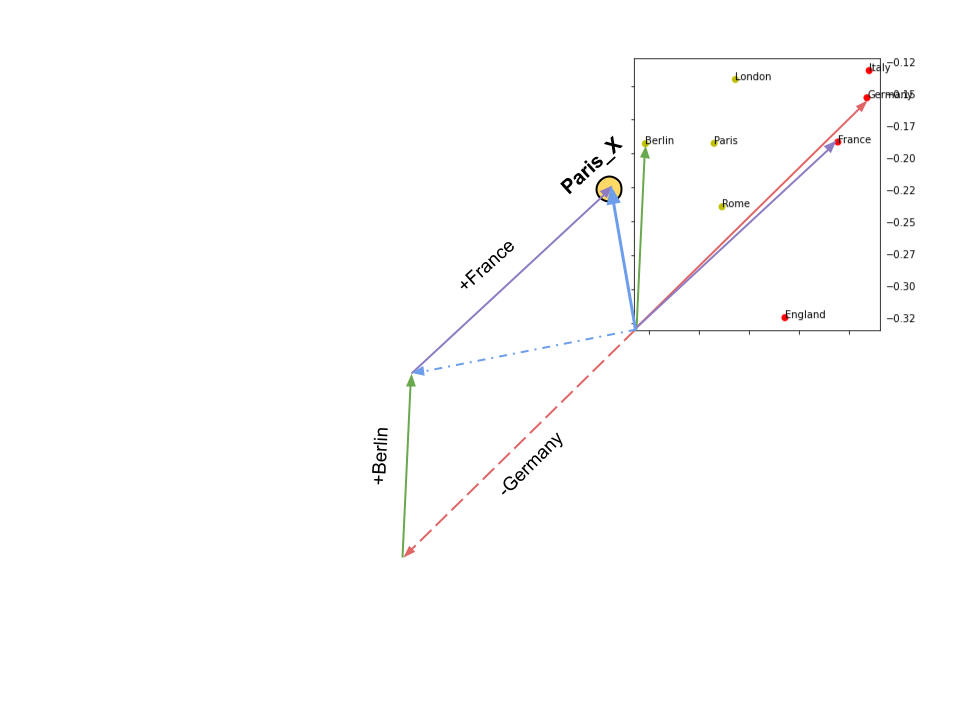

But looking at the PCA plot if we try to reproduce the above operations with vectors it does NOT work: `Berlin - Germany + France` is closer to `Berlin` itself than to `Paris`. Indeed from the PCA Germany and France are really close but looking at the cosine similarity Germany is closer to Berlin than to France.

In [ ]:
'Similarity Germany,France', 1 - cosine(model["Germany"], model["France"])

In [ ]:
'Similarity Germany,Berlin', 1 - cosine(model["Germany"], model["Berlin"])

In [ ]:
# Finally if we plot only these 4 words, they look distant in the plot.
# while we saw them close when plotting them together with several other words.
quick_plot(
    words=["Rome", "Paris", "Berlin", "London"],
    embedding=model)

# Quick Classification with Word Embeddings

You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

get the data here: https://www.kaggle.com/c/nlp-getting-started/data?select=train.csv

Or download it from this github repo (with the following command): https://raw.githubusercontent.com/nikjohn7/Disaster-Tweets-Kaggle/main/data/train.csv

In [ ]:
!wget https://raw.githubusercontent.com/nikjohn7/Disaster-Tweets-Kaggle/main/data/train.csv

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("train.csv")
df.head(25)

In [ ]:
X_text = df["text"]
y = df["target"]

In [ ]:
def naive_sentence_embedding(text, embedding, mean_embedding):
  """
  Embeds a sentence by making the average of the word embedding in the sentence
  There are several ways to make this better and smarter.
  Google "sentence embeddings"

  if a word is missing from the vocabulary we add this generic mean vecor
  of the entire space
  """
  text = simple_preproc(text.lower())
  collect = []
  for a in text.split():
    if a in embedding.vocab:
      collect.append(embedding[a])
    else:
      collect.append(mean_embedding)

  return np.mean(collect, axis=0)

mean_vector = np.mean(model[model.vocab], axis=0)

In [ ]:
train_X = np.array([naive_sentence_embedding(tt, model, mean_vector) for tt in X_text])

In [ ]:
train_X.shape

In [ ]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_X, y, test_size=0.33, random_state=42, shuffle=True)

In [ ]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

In [ ]:
example = "This is a real disaster!"
embedding_example = naive_sentence_embedding(example, model, mean_vector)

logreg.predict(np.array([embedding_example]))


In [ ]:
example = "The cat is on the table"
embedding_example = naive_sentence_embedding(example, model, mean_vector)

logreg.predict(np.array([embedding_example]))


In [ ]:
predictions = logreg.predict(X_test)
f1_score(y_test, predictions)